0. Setup


In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, Subset, Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

1. Loading Individual Datasets


In [88]:
# Helper function to use a dataset to create a balanced dataset that makes
# sure each class has the same number of samples.
def create_balanced_dataset(test_dataset, target_samples_per_class=500):
    # Gather labels from the test dataset.
    test_labels = []
    for i in range(len(test_dataset)):
        _, label = test_dataset[i]  
        # Extract the label from the dataset item.
        test_labels.append(label.item())

    # Count samples per class in the test dataset
    class_counts = Counter(test_labels)
    print(f"Original class distribution: {dict(class_counts)}")

    # Identify classes that need oversampling
    classes_to_oversample = {
        cls: (target_samples_per_class - count)
        for cls, count in class_counts.items()
        if count < target_samples_per_class
    }

    # If no class is under the target, simply return the original dataset
    if not classes_to_oversample:
        print("No oversampling needed - all classes have enough samples.")
        return test_dataset

    # Map each class to the list of indices that contain that class
    class_indices_map = {cls: [] for cls in class_counts.keys()}
    for i, lbl in enumerate(test_labels):
        class_indices_map[lbl].append(i)

    # Generate the new indices by oversampling
    additional_indices = []
    for cls, num_needed in classes_to_oversample.items():
        # Randomly sample (with replacement) from the available indices of this class
        oversampled = np.random.choice(class_indices_map[cls], size=num_needed, replace=True)
        additional_indices.extend(oversampled)

    # Combine original indices with the newly oversampled ones
    all_indices = list(range(len(test_dataset))) + additional_indices

    # Create a new Subset using these indices
    balanced_dataset = Subset(test_dataset, all_indices)

    # Optional: verify the new distribution
    balanced_labels = []
    for idx in all_indices:
        _, label = test_dataset[idx]
        balanced_labels.append(int(label))
    balanced_counts = Counter(balanced_labels)
    print(f"Balanced class distribution: {dict(balanced_counts)}")

    return balanced_dataset

In [89]:
# Load the audio test dataset from the .pt file.
audio_dataset = torch.load("../../Data/audio_test_dataset.pt")
# Create a balanced dataset with 500 samples per class.
balanced_audio_dataset = create_balanced_dataset(audio_dataset, target_samples_per_class=500)
# Print out the size of the dataset.
print(f"Size of the balanced dataset: {len(balanced_audio_dataset)}")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_1239/2291915788.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_dataset = torch.load("../../Data/audio_t

Original class distribution: {5: 70, 35: 37, 20: 83, 11: 42, 29: 100, 28: 56, 6: 67, 10: 58, 19: 100, 44: 31, 12: 68, 34: 92, 21: 58, 37: 100, 8: 34, 31: 40, 40: 35, 25: 42, 22: 62, 42: 42, 0: 33, 30: 100, 14: 52, 23: 100, 27: 31, 7: 100, 18: 100, 45: 66, 41: 30, 9: 37, 2: 57, 13: 60, 3: 67, 43: 45, 15: 37, 26: 36, 4: 73, 32: 57, 33: 34, 38: 42, 46: 67, 24: 41, 1: 48, 39: 32, 17: 39, 36: 39, 16: 42}
Balanced class distribution: {5: 500, 35: 500, 20: 500, 11: 500, 29: 500, 28: 500, 6: 500, 10: 500, 19: 500, 44: 500, 12: 500, 34: 500, 21: 500, 37: 500, 8: 500, 31: 500, 40: 500, 25: 500, 22: 500, 42: 500, 0: 500, 30: 500, 14: 500, 23: 500, 27: 500, 7: 500, 18: 500, 45: 500, 41: 500, 9: 500, 2: 500, 13: 500, 3: 500, 43: 500, 15: 500, 26: 500, 4: 500, 32: 500, 33: 500, 38: 500, 46: 500, 24: 500, 1: 500, 39: 500, 17: 500, 36: 500, 16: 500}
Size of the balanced dataset: 23500


In [90]:
# Now load the image test dataset from the .pt file.
images_dataset = torch.load("../../Data/resnet_test_dataset.pt")
# Create a balanced dataset with 500 samples per class.
balanced_images_dataset = create_balanced_dataset(images_dataset, target_samples_per_class=500)
# Print out the size of the dataset.
print(f"Size of the balanced dataset: {len(balanced_images_dataset)}")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_1239/3935245663.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images_dataset = torch.load("../../Data/resnet

Original class distribution: {28: 24, 20: 21, 17: 24, 34: 24, 18: 24, 37: 24, 39: 24, 0: 23, 9: 24, 33: 23, 46: 24, 13: 24, 4: 24, 5: 20, 14: 24, 11: 24, 23: 23, 21: 24, 19: 23, 2: 24, 36: 24, 26: 24, 27: 24, 12: 22, 15: 24, 45: 24, 44: 24, 32: 22, 41: 24, 35: 22, 42: 24, 43: 23, 16: 22, 30: 22, 31: 24, 22: 24, 3: 23, 38: 24, 24: 24, 8: 21, 25: 21, 7: 22, 1: 24, 10: 24, 6: 23, 29: 24, 40: 22}
Balanced class distribution: {28: 500, 20: 500, 17: 500, 34: 500, 18: 500, 37: 500, 39: 500, 0: 500, 9: 500, 33: 500, 46: 500, 13: 500, 4: 500, 5: 500, 14: 500, 11: 500, 23: 500, 21: 500, 19: 500, 2: 500, 36: 500, 26: 500, 27: 500, 12: 500, 15: 500, 45: 500, 44: 500, 32: 500, 41: 500, 35: 500, 42: 500, 43: 500, 16: 500, 30: 500, 31: 500, 22: 500, 3: 500, 38: 500, 24: 500, 8: 500, 25: 500, 7: 500, 1: 500, 10: 500, 6: 500, 29: 500, 40: 500}
Size of the balanced dataset: 23500


2. Creating Combined Dataloaders


In [91]:
# Extract the images data and labels from the balanced dataset
images_data = []
images_labels = []
for i in range(len(balanced_images_dataset)):
    image, label = balanced_images_dataset[i]
    images_data.append(image)
    images_labels.append(label)
# Convert to tensors
images_data_tensor = torch.stack(images_data)
images_labels_tensor = torch.tensor(images_labels)
print(f"Images data tensor shape: {images_data_tensor.shape}")
print(f"Images labels tensor shape: {images_labels_tensor.shape}")

Images data tensor shape: torch.Size([23500, 1, 512])
Images labels tensor shape: torch.Size([23500])


In [92]:
# Extract the audio data from the balanced dataset.
audio_data = []
audio_labels = []
for i in range(len(balanced_audio_dataset)):
    audio, label = balanced_audio_dataset[i]
    audio_data.append(audio)
    audio_labels.append(label)
# Convert the data and labels to PyTorch tensors.
audio_data_tensor = torch.stack(audio_data)
audio_labels_tensor = torch.tensor(audio_labels)
print(f"Balanced audio data tensor shape: {audio_data_tensor.shape}")
print(f"Balanced audio labels tensor shape: {audio_labels_tensor.shape}")

Balanced audio data tensor shape: torch.Size([23500, 1, 128, 128])
Balanced audio labels tensor shape: torch.Size([23500])


In [99]:
# We define a class to create a dataset for the audio and image data.
# We want to create random pairs of audio and image data, of the same class.
class MultimodalFusionDataset(Dataset):
    def __init__(self, image_data, image_labels, audio_data, audio_labels, transform=None, indices=None):
        """
        Custom dataset for multimodal fusion of image and audio data.
        
        Args:
            image_data: PyTorch tensor containing image data
            image_labels: PyTorch tensor containing image labels
            audio_data: PyTorch tensor containing audio data
            audio_labels: PyTorch tensor containing audio labels
            transform: Optional transform to be applied to the samples
            indices: Optional indices to select a subset of the data
        """
        self.image_data = image_data
        self.image_labels = image_labels
        self.audio_data = audio_data
        self.audio_labels = audio_labels
        self.transform = transform
        
        # Convert tensors to numpy for processing
        image_labels_np = image_labels.numpy()
        audio_labels_np = audio_labels.numpy()
        
        # Create a list of all possible class indices - ensure they're the same for both modalities
        image_classes = set(np.unique(image_labels_np))
        audio_classes = set(np.unique(audio_labels_np))
        common_classes = sorted(list(image_classes.intersection(audio_classes)))
        
        if len(common_classes) == 0:
            raise ValueError("No common classes found between image and audio datasets")
        
        # Organize samples by class
        self.class_indices = {}
        self.pairs = []
        self.pair_labels = []
        
        for cls in common_classes:
            img_indices = np.where(image_labels_np == cls)[0]
            audio_indices = np.where(audio_labels_np == cls)[0]
            
            if len(img_indices) > 0 and len(audio_indices) > 0:
                self.class_indices[cls] = {
                    'image': img_indices,
                    'audio': audio_indices
                }
                
                # Shuffle the indices for random pairing
                np.random.seed(42)  # For reproducibility
                np.random.shuffle(img_indices)
                np.random.shuffle(audio_indices)
                
                # Create pairs (one image with one audio) from the same class
                n_pairs = min(len(img_indices), len(audio_indices))
                for i in range(n_pairs):
                    self.pairs.append((img_indices[i], audio_indices[i]))
                    self.pair_labels.append(cls)
        
        # Check if we have any pairs
        if len(self.pairs) == 0:
            raise ValueError("No valid pairs could be created. Check your data and labels.")
        
        # Convert to numpy arrays for easier indexing
        self.pairs = np.array(self.pairs)
        self.pair_labels = np.array(self.pair_labels)
        
        # If specific indices are provided, only use those
        if indices is not None:
            if len(indices) > 0:  # Make sure indices is not empty
                self.pairs = self.pairs[indices]
                self.pair_labels = self.pair_labels[indices]
            else:
                raise ValueError("Empty indices provided")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_idx, audio_idx = self.pairs[idx]
        
        image = self.image_data[img_idx]
        audio = self.audio_data[audio_idx]
        label = torch.tensor(self.pair_labels[idx], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'audio': audio,
            'label': label
        }


# Create stratified data loaders for training, validation, and testing
# These will be created using the dataset framework we defined above,
# and using the balanced datasets we created earlier.
def create_stratified_data_loaders(image_data, image_labels, audio_data, audio_labels, batch_size=32):
    """
    Create train, validation, and test data loaders with stratified splits.
    
    Args:
        image_data: PyTorch tensor containing image data
        image_labels: PyTorch tensor containing image labels
        audio_data: PyTorch tensor containing audio data
        audio_labels: PyTorch tensor containing audio labels
        batch_size: Batch size for the data loaders
        num_workers: Number of worker threads for the data loaders
        
    Returns:
        train_loader, val_loader, test_loader
    """
    # First, create the full dataset
    try:
        full_dataset = MultimodalFusionDataset(
            image_data=image_data,
            image_labels=image_labels,
            audio_data=audio_data,
            audio_labels=audio_labels
        )
    except ValueError as e:
        print(f"Error creating dataset: {e}")
        print(f"Image labels shape: {image_labels.shape}, unique: {torch.unique(image_labels).shape}")
        print(f"Audio labels shape: {audio_labels.shape}, unique: {torch.unique(audio_labels).shape}")
        raise
    
    # Get all pair labels
    pair_labels = full_dataset.pair_labels
    
    # Create indices array
    indices = np.arange(len(pair_labels))
    
    # First split: train+val vs test (80:20)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    temp_idx, test_idx = next(sss1.split(indices, pair_labels))
    
    # Get the temporary set labels
    temp_labels = pair_labels[temp_idx]
    
    # Second split: train vs val (80:20)
    temp_indices = np.arange(len(temp_idx))
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    train_temp_idx, val_temp_idx = next(sss2.split(temp_indices, temp_labels))
    
    # Convert to original indices
    train_idx = temp_idx[train_temp_idx]
    val_idx = temp_idx[val_temp_idx]
    
    # Create the individual datasets
    train_dataset = MultimodalFusionDataset(
        image_data=image_data,
        image_labels=image_labels,
        audio_data=audio_data,
        audio_labels=audio_labels,
        indices=train_idx
    )
    
    val_dataset = MultimodalFusionDataset(
        image_data=image_data,
        image_labels=image_labels,
        audio_data=audio_data,
        audio_labels=audio_labels,
        indices=val_idx
    )
    
    test_dataset = MultimodalFusionDataset(
        image_data=image_data,
        image_labels=image_labels,
        audio_data=audio_data,
        audio_labels=audio_labels,
        indices=test_idx
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    
    # Print split information
    print(f"Dataset split: {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples")
    
    return train_loader, val_loader, test_loader

In [102]:
# Use the extracted tensors to create stratified data loaders
batch_size = 32
train_loader, val_loader, test_loader = create_stratified_data_loaders(
    image_data=images_data_tensor,
    image_labels=images_labels_tensor,
    audio_data=audio_data_tensor,
    audio_labels=audio_labels_tensor,
    batch_size=batch_size,
)

Dataset split: 15040 training, 3760 validation, 4700 test samples


3. Fusion Model


In [105]:
# Start by defining the Fusion ANN Model.
class FusionANN(nn.Module):
    def __init__(self, image_embed_size, audio_embed_size, hidden_dim, num_classes, dropout_rate=0.5):
        super(FusionANN, self).__init__()
        
        # Dimensionality of inputs
        self.image_embed_size = image_embed_size
        self.audio_embed_size = audio_embed_size
        
        # Fusion network
        self.fusion_network = nn.Sequential(
            nn.Linear(image_embed_size + audio_embed_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, image_features, audio_features):
        # Concatenate features from both modalities
        combined_features = torch.cat((image_features, audio_features), dim=1)
        
        # Pass through fusion network
        output = self.fusion_network(combined_features)
        
        return output


In [106]:
# Define the images model.
class ImagesResNetANN(nn.Module):
    def __init__(self, num_classes=47, dropout_rate=0.3):
        super(ImagesResNetANN, self).__init__()
        self.name = "ImagesResNetANN_1"
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x shape: [batch_size, 1, 512]
        # Flatten the feature map to [batch_size, 512]
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [107]:
# Define the Audio CNN Model.
class SpecCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(SpecCNN, self).__init__()
        self.name = "Spec_WAV10_CNN_5"
        
        # Adding dropout with default rate of 0.3
        self.dropout = nn.Dropout(dropout_rate)
        
        # Following the architecture from the paper
        # Adjusted for input channels = 1 (grayscale)
        # Conv Group 1: [1, 128, 128] -> [64, 64, 64]
        self.conv_group1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.bn_group1 = nn.BatchNorm2d(64)
        
        # Conv Group 2: [64, 64, 64] -> [128, 32, 32]
        self.conv_group2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn_group2 = nn.BatchNorm2d(128)
        
        # Conv Group 3: [128, 32, 32] -> [256, 16, 16]
        self.conv_group3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn_group3 = nn.BatchNorm2d(256)
        
        # Conv Group 4: [256, 16, 16] -> [512, 8, 8]
        self.conv_group4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn_group4 = nn.BatchNorm2d(512)
        
        # Conv Group 5: [512, 8, 8] -> [1024, 4, 4]
        self.conv_group5 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.bn_group5 = nn.BatchNorm2d(1024)
        
        # 1x1 Convolution: [1024, 4, 4] -> [2048, 4, 4]
        self.conv_1x1 = nn.Conv2d(1024, 2048, kernel_size=1)
        self.bn_1x1 = nn.BatchNorm2d(2048)
        
        # Global Average Pooling: [2048, 4, 4] -> [2048, 1, 1]
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        # Input: [batch_size, 1, 128, 128] (channels, height, width)
        # No need to transform dimensions as input is already in correct format
        
        # Handle different input shapes (just in case)
        if x.dim() == 3 and x.shape[0] == 1:  # If x has shape [1, H, W] (single grayscale image)
            x = x.unsqueeze(0)  # Add batch dimension: [1, 1, H, W]
            
        # Apply convolutional layers with dropout
        x = F.relu(self.bn_group1(self.conv_group1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group2(self.conv_group2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group3(self.conv_group3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group4(self.conv_group4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group5(self.conv_group5(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_1x1(self.conv_1x1(x)))
        
        # Global average pooling
        x = self.avg_pool(x)
        
        # Flatten: [batch, 2048, 1, 1] -> [batch, 2048]
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        
        # Apply dropout before the final fully connected layer
        x = self.dropout(x)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

In [108]:
# Function to load pre-trained models
def load_pretrained_models(image_model_path, audio_model_path, device):
    # Load image model
    image_model = ImagesResNetANN()
    image_model.load_state_dict(torch.load(image_model_path))
    image_model.to(device)
    image_model.eval()  # Set to evaluation mode
    
    # Load audio model
    audio_model = SpecCNN(num_classes = 47)
    audio_model.load_state_dict(torch.load(audio_model_path))
    audio_model.to(device)
    audio_model.eval()  # Set to evaluation mode
    
    return image_model, audio_model

In [109]:
# Function to extract features from the pre-trained models
def extract_features(image_model, audio_model, dataloader, device):
    image_features_list = []
    audio_features_list = []
    labels_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            images = batch['image'].to(device)
            audio = batch['audio'].to(device)
            labels = batch['label']
            
            # Extract features from the pre-trained models
            image_features = image_model(images)
            audio_features = audio_model(audio)
            
            image_features_list.append(image_features)
            audio_features_list.append(audio_features)
            labels_list.append(labels)
    
    return image_features_list, audio_features_list, labels_list

In [115]:
def train_fusion_model(fusion_model, train_image_features, train_audio_features, train_labels,
                       val_image_features, val_audio_features, val_labels,
                       num_epochs, batch_size, learning_rate, device):
    # Define loss function, optimizer, and learning rate scheduler.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fusion_model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    # Training history lists.
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Get the number of batches.
    num_train_batches = len(train_image_features)
    num_val_batches = len(val_image_features)
    
    # Compute the total number of samples by summing batch sizes.
    num_train_samples = sum(batch.shape[0] for batch in train_image_features)
    num_val_samples = sum(batch.shape[0] for batch in val_image_features)
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        fusion_model.train()
        running_train_loss = 0.0
        correct_train = 0
        
        for batch_idx in tqdm(range(num_train_batches), desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Get batch data and move to the device.
            batch_image_features = train_image_features[batch_idx].to(device)
            batch_audio_features = train_audio_features[batch_idx].to(device)
            batch_labels = train_labels[batch_idx].to(device)
            
            # Zero the gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            outputs = fusion_model(batch_image_features, batch_audio_features)
            
            # Calculate loss.
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and update weights.
            loss.backward()
            optimizer.step()
            
            # Accumulate loss scaled by the current batch size.
            running_train_loss += loss.item() * batch_labels.size(0)
            
            # Count correct predictions.
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_labels).sum().item()
        
        train_loss = running_train_loss / num_train_samples
        train_accuracy = correct_train / num_train_samples
        
        # Validation phase (using batch iteration similar to training)
        fusion_model.eval()
        running_val_loss = 0.0
        correct_val = 0
        
        with torch.no_grad():
            for batch_idx in range(num_val_batches):
                batch_image_features = val_image_features[batch_idx].to(device)
                batch_audio_features = val_audio_features[batch_idx].to(device)
                batch_labels = val_labels[batch_idx].to(device)
                
                outputs = fusion_model(batch_image_features, batch_audio_features)
                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item() * batch_labels.size(0)
                
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_labels).sum().item()
        
        val_loss = running_val_loss / num_val_samples
        val_accuracy = correct_val / num_val_samples
        
        # Step the scheduler using validation loss.
        scheduler.step(val_loss)
        
        # Save statistics.
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Save the best model state.
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = fusion_model.state_dict().copy()
            print(f"New best model with validation accuracy: {best_val_acc:.4f}")
    
    # Load the best model state.
    if best_model_state is not None:
        fusion_model.load_state_dict(best_model_state)
    
    # Return the model along with the training history.
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    
    return fusion_model, history

In [122]:
def evaluate_model(fusion_model, test_image_features, test_audio_features, test_labels, device):
    fusion_model.eval()
    total_samples = 0
    correct_total = 0
    class_correct = None
    class_total = None

    num_batches = len(test_image_features)
    with torch.no_grad():
        for batch_idx in range(num_batches):
            # Get batch data and move to the device
            batch_image_features = test_image_features[batch_idx].to(device)
            batch_audio_features = test_audio_features[batch_idx].to(device)
            batch_labels = test_labels[batch_idx].to(device)
            
            # Forward pass
            outputs = fusion_model(batch_image_features, batch_audio_features)
            _, predicted = torch.max(outputs, 1)
            
            # Update overall test accuracy
            batch_size = batch_labels.size(0)
            total_samples += batch_size
            correct_total += (predicted == batch_labels).sum().item()
            
            # Initialize per-class counters on the first batch
            if class_correct is None:
                num_classes = outputs.size(1)
                class_correct = [0] * num_classes
                class_total = [0] * num_classes
                
            # Update per-class statistics
            for i in range(batch_size):
                label = batch_labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
    
    test_accuracy = correct_total / total_samples
    class_accuracy = [class_correct[i] / (class_total[i] + 1e-8) for i in range(len(class_correct))]
    return test_accuracy, class_accuracy

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('fusion_model_training_history.png')
    plt.show()


In [117]:
"""FOR MACBOOK LOCAL SETUP USERS ONLY """
use_mps = True
# Set device to GPU if available
device = torch.device("mps") if use_mps and torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [118]:
# Now we run and train the model.

# Load pre-trained models
image_model_path = "Models/best_images_model.pt"
audio_model_path = "Models/T_0.9394_V_0.6755.pt"
image_model, audio_model = load_pretrained_models(image_model_path, audio_model_path, device)

# Extract features from the training and validation sets
train_image_features, train_audio_features, train_labels = extract_features(image_model, audio_model, train_loader, device)
val_image_features, val_audio_features, val_labels = extract_features(image_model, audio_model, val_loader, device)

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_1239/3139589982.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_model.load_state_dict(torch.load(image_m

In [119]:
print(f"Train image features list shape: {len(train_image_features)}")
print(f"Train audio features list shape: {len(train_audio_features)}")
print(f"Train labels list shape: {len(train_labels)}")

print(f"Train image features shape: {train_image_features[0].shape}")
print(f"Train audio features shape: {train_audio_features[0].shape}")
print(f"Train labels shape: {train_labels[0].shape}")

print(f"Validation image features list shape: {len(val_image_features)}")
print(f"Validation audio features list shape: {len(val_audio_features)}")
print(f"Validation labels list shape: {len(val_labels)}")

print(f"Validation image features shape: {val_image_features[0].shape}")
print(f"Validation audio features shape: {val_audio_features[0].shape}")
print(f"Validation labels shape: {val_labels[0].shape}")

Train image features list shape: 470
Train audio features list shape: 470
Train labels list shape: 470
Train image features shape: torch.Size([32, 47])
Train audio features shape: torch.Size([32, 47])
Train labels shape: torch.Size([32])
Validation image features list shape: 117
Validation audio features list shape: 117
Validation labels list shape: 117
Validation image features shape: torch.Size([32, 47])
Validation audio features shape: torch.Size([32, 47])
Validation labels shape: torch.Size([32])


/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 315.86it/s]


Epoch 1/50 - Train Loss: 2.1660, Train Acc: 0.4294, Val Loss: 0.6105, Val Acc: 0.8723
New best model with validation accuracy: 0.8723


Epoch 2/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 376.07it/s]


Epoch 2/50 - Train Loss: 0.7227, Train Acc: 0.7852, Val Loss: 0.3238, Val Acc: 0.9217
New best model with validation accuracy: 0.9217


Epoch 3/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 388.50it/s]


Epoch 3/50 - Train Loss: 0.5009, Train Acc: 0.8477, Val Loss: 0.2506, Val Acc: 0.9346
New best model with validation accuracy: 0.9346


Epoch 4/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 384.17it/s]


Epoch 4/50 - Train Loss: 0.3872, Train Acc: 0.8803, Val Loss: 0.2031, Val Acc: 0.9460
New best model with validation accuracy: 0.9460


Epoch 5/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 340.69it/s]


Epoch 5/50 - Train Loss: 0.3231, Train Acc: 0.8991, Val Loss: 0.1724, Val Acc: 0.9509
New best model with validation accuracy: 0.9509


Epoch 6/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 370.62it/s]


Epoch 6/50 - Train Loss: 0.2822, Train Acc: 0.9098, Val Loss: 0.1533, Val Acc: 0.9567
New best model with validation accuracy: 0.9567


Epoch 7/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 388.77it/s]


Epoch 7/50 - Train Loss: 0.2394, Train Acc: 0.9269, Val Loss: 0.1335, Val Acc: 0.9615
New best model with validation accuracy: 0.9615


Epoch 8/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 381.10it/s]


Epoch 8/50 - Train Loss: 0.2200, Train Acc: 0.9309, Val Loss: 0.1250, Val Acc: 0.9639
New best model with validation accuracy: 0.9639


Epoch 9/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 339.36it/s]


Epoch 9/50 - Train Loss: 0.1989, Train Acc: 0.9370, Val Loss: 0.1172, Val Acc: 0.9666
New best model with validation accuracy: 0.9666


Epoch 10/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 383.78it/s]


Epoch 10/50 - Train Loss: 0.1789, Train Acc: 0.9441, Val Loss: 0.1075, Val Acc: 0.9685
New best model with validation accuracy: 0.9685


Epoch 11/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 380.35it/s]


Epoch 11/50 - Train Loss: 0.1654, Train Acc: 0.9483, Val Loss: 0.0997, Val Acc: 0.9712
New best model with validation accuracy: 0.9712


Epoch 12/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 379.06it/s]


Epoch 12/50 - Train Loss: 0.1539, Train Acc: 0.9516, Val Loss: 0.0877, Val Acc: 0.9733
New best model with validation accuracy: 0.9733


Epoch 13/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 346.83it/s]


Epoch 13/50 - Train Loss: 0.1444, Train Acc: 0.9537, Val Loss: 0.0858, Val Acc: 0.9736
New best model with validation accuracy: 0.9736


Epoch 14/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 300.19it/s]


Epoch 14/50 - Train Loss: 0.1296, Train Acc: 0.9591, Val Loss: 0.0812, Val Acc: 0.9768
New best model with validation accuracy: 0.9768


Epoch 15/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 304.27it/s]


Epoch 15/50 - Train Loss: 0.1209, Train Acc: 0.9622, Val Loss: 0.0732, Val Acc: 0.9781
New best model with validation accuracy: 0.9781


Epoch 16/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 302.87it/s]


Epoch 16/50 - Train Loss: 0.1133, Train Acc: 0.9644, Val Loss: 0.0690, Val Acc: 0.9805
New best model with validation accuracy: 0.9805


Epoch 17/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 281.25it/s]


Epoch 17/50 - Train Loss: 0.1043, Train Acc: 0.9679, Val Loss: 0.0656, Val Acc: 0.9794


Epoch 18/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 300.82it/s]


Epoch 18/50 - Train Loss: 0.0982, Train Acc: 0.9693, Val Loss: 0.0639, Val Acc: 0.9789


Epoch 19/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 321.67it/s]


Epoch 19/50 - Train Loss: 0.0927, Train Acc: 0.9711, Val Loss: 0.0570, Val Acc: 0.9842
New best model with validation accuracy: 0.9842


Epoch 20/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 353.91it/s]


Epoch 20/50 - Train Loss: 0.0854, Train Acc: 0.9731, Val Loss: 0.0536, Val Acc: 0.9850
New best model with validation accuracy: 0.9850


Epoch 21/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 340.86it/s]


Epoch 21/50 - Train Loss: 0.0800, Train Acc: 0.9761, Val Loss: 0.0509, Val Acc: 0.9840


Epoch 22/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 319.45it/s]


Epoch 22/50 - Train Loss: 0.0784, Train Acc: 0.9759, Val Loss: 0.0518, Val Acc: 0.9834


Epoch 23/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 294.04it/s]


Epoch 23/50 - Train Loss: 0.0721, Train Acc: 0.9790, Val Loss: 0.0450, Val Acc: 0.9856
New best model with validation accuracy: 0.9856


Epoch 24/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 320.54it/s]


Epoch 24/50 - Train Loss: 0.0675, Train Acc: 0.9802, Val Loss: 0.0422, Val Acc: 0.9866
New best model with validation accuracy: 0.9866


Epoch 25/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 325.16it/s]


Epoch 25/50 - Train Loss: 0.0619, Train Acc: 0.9830, Val Loss: 0.0431, Val Acc: 0.9866


Epoch 26/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 313.67it/s]


Epoch 26/50 - Train Loss: 0.0582, Train Acc: 0.9824, Val Loss: 0.0438, Val Acc: 0.9861


Epoch 27/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 324.72it/s]


Epoch 27/50 - Train Loss: 0.0600, Train Acc: 0.9823, Val Loss: 0.0392, Val Acc: 0.9874
New best model with validation accuracy: 0.9874


Epoch 28/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 339.31it/s]


Epoch 28/50 - Train Loss: 0.0552, Train Acc: 0.9816, Val Loss: 0.0381, Val Acc: 0.9885
New best model with validation accuracy: 0.9885


Epoch 29/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 374.66it/s]


Epoch 29/50 - Train Loss: 0.0531, Train Acc: 0.9838, Val Loss: 0.0427, Val Acc: 0.9872


Epoch 30/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 372.96it/s]


Epoch 30/50 - Train Loss: 0.0489, Train Acc: 0.9862, Val Loss: 0.0373, Val Acc: 0.9872


Epoch 31/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 367.21it/s]


Epoch 31/50 - Train Loss: 0.0437, Train Acc: 0.9868, Val Loss: 0.0351, Val Acc: 0.9899
New best model with validation accuracy: 0.9899


Epoch 32/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 327.85it/s]


Epoch 32/50 - Train Loss: 0.0497, Train Acc: 0.9843, Val Loss: 0.0344, Val Acc: 0.9896


Epoch 33/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 306.03it/s]


Epoch 33/50 - Train Loss: 0.0446, Train Acc: 0.9856, Val Loss: 0.0357, Val Acc: 0.9853


Epoch 34/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 322.91it/s]


Epoch 34/50 - Train Loss: 0.0420, Train Acc: 0.9880, Val Loss: 0.0295, Val Acc: 0.9896


Epoch 35/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 348.30it/s]


Epoch 35/50 - Train Loss: 0.0370, Train Acc: 0.9888, Val Loss: 0.0290, Val Acc: 0.9901
New best model with validation accuracy: 0.9901


Epoch 36/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 348.53it/s]


Epoch 36/50 - Train Loss: 0.0394, Train Acc: 0.9880, Val Loss: 0.0292, Val Acc: 0.9912
New best model with validation accuracy: 0.9912


Epoch 37/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 314.54it/s]


Epoch 37/50 - Train Loss: 0.0353, Train Acc: 0.9905, Val Loss: 0.0300, Val Acc: 0.9912


Epoch 38/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 342.95it/s]


Epoch 38/50 - Train Loss: 0.0367, Train Acc: 0.9892, Val Loss: 0.0268, Val Acc: 0.9904


Epoch 39/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 277.23it/s]


Epoch 39/50 - Train Loss: 0.0343, Train Acc: 0.9898, Val Loss: 0.0262, Val Acc: 0.9923
New best model with validation accuracy: 0.9923


Epoch 40/50 - Training: 100%|██████████| 470/470 [00:02<00:00, 184.16it/s]


Epoch 40/50 - Train Loss: 0.0319, Train Acc: 0.9906, Val Loss: 0.0229, Val Acc: 0.9923


Epoch 41/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 320.44it/s]


Epoch 41/50 - Train Loss: 0.0304, Train Acc: 0.9916, Val Loss: 0.0223, Val Acc: 0.9944
New best model with validation accuracy: 0.9944


Epoch 42/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 338.16it/s]


Epoch 42/50 - Train Loss: 0.0298, Train Acc: 0.9918, Val Loss: 0.0219, Val Acc: 0.9925


Epoch 43/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 361.17it/s]


Epoch 43/50 - Train Loss: 0.0277, Train Acc: 0.9918, Val Loss: 0.0261, Val Acc: 0.9917


Epoch 44/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 368.34it/s]


Epoch 44/50 - Train Loss: 0.0283, Train Acc: 0.9918, Val Loss: 0.0244, Val Acc: 0.9931


Epoch 45/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 371.78it/s]


Epoch 45/50 - Train Loss: 0.0256, Train Acc: 0.9916, Val Loss: 0.0239, Val Acc: 0.9923


Epoch 46/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 348.95it/s]


Epoch 46/50 - Train Loss: 0.0268, Train Acc: 0.9924, Val Loss: 0.0244, Val Acc: 0.9917


Epoch 47/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 324.44it/s]


Epoch 47/50 - Train Loss: 0.0259, Train Acc: 0.9915, Val Loss: 0.0250, Val Acc: 0.9923


Epoch 48/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 353.71it/s]


Epoch 48/50 - Train Loss: 0.0261, Train Acc: 0.9924, Val Loss: 0.0213, Val Acc: 0.9920


Epoch 49/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 300.63it/s]


Epoch 49/50 - Train Loss: 0.0236, Train Acc: 0.9932, Val Loss: 0.0200, Val Acc: 0.9947
New best model with validation accuracy: 0.9947


Epoch 50/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 364.43it/s]


Epoch 50/50 - Train Loss: 0.0216, Train Acc: 0.9941, Val Loss: 0.0195, Val Acc: 0.9933


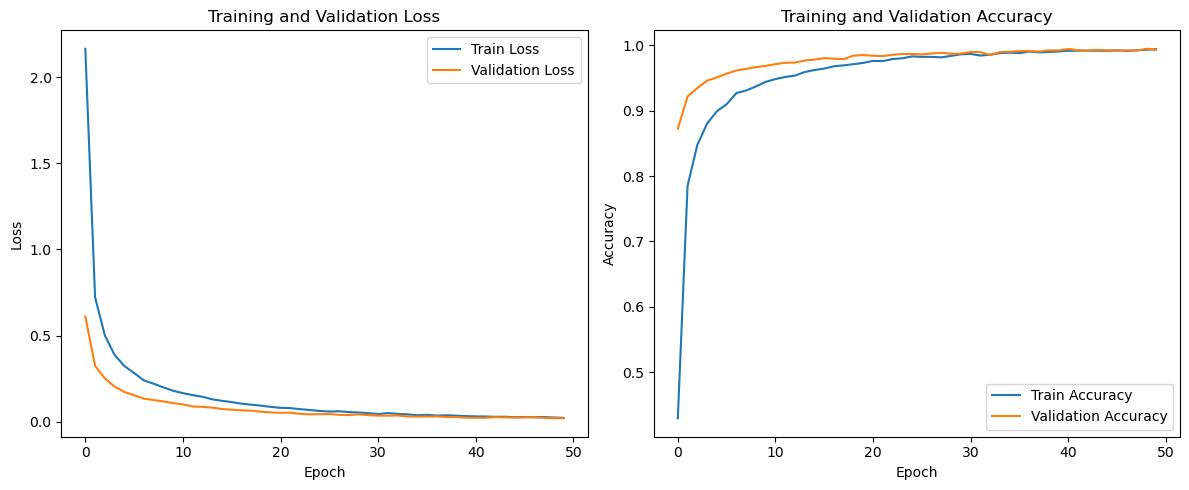

In [125]:
# Now we train the fusion model.
num_classes = 47
num_epochs = 50
learning_rate = 0.0001
dropout_rate = 0.3
image_embed_size = train_image_features[0].shape[1]
audio_embed_size = train_audio_features[0].shape[1]
hidden_dim = 512
# Create the fusion model
fusion_model = FusionANN(image_embed_size, audio_embed_size, hidden_dim, num_classes, dropout_rate)
fusion_model.to(device)
# Train the model.
_, history = train_fusion_model(fusion_model, 
                                train_image_features, 
                                train_audio_features, 
                                train_labels, 
                                val_image_features, 
                                val_audio_features, 
                                val_labels, 
                                num_epochs=num_epochs, 
                                batch_size=batch_size, 
                                learning_rate=learning_rate, 
                                device=device)
# Plot the training history
plot_training_history(history)


In [126]:
# Test the model on the test set.
test_image_features, test_audio_features, test_labels = extract_features(image_model, audio_model, test_loader, device)
test_accuracy, class_accuracy = evaluate_model(fusion_model, test_image_features, test_audio_features, test_labels, device)
print(f"Test Accuracy: {test_accuracy:.4f}")

100%|██████████| 146/146 [00:02<00:00, 67.19it/s]


Test Accuracy: 0.9953
